# Bend Contour Test Notebook

Henry Bell 06/09/2025

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
from crystals import Crystal 
import pandas as pd
from tqdm import tqdm
import ncempy.io.dm as dm
GPU_use = 2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # consistent GPU ordering
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_use)
os.environ["OMP_NUM_THREADS"] = "1"

import cupy as cp
%matplotlib widget

GPU = True
from cupyx.profiler import benchmark
if GPU:
    xp = cp
    xp.cuda.Device(0).use()
else:
    xp = np

import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(os.path.dirname(parent_dir), "Si_data_03202025")
sys.path.append(parent_dir)
sys.path.append(data_dir)


import os
import sys

# Get the absolute path to the src directory (2 levels up from tests)
current_dir = os.getcwd()
src_dir = os.path.dirname(os.path.dirname(os.path.dirname(current_dir)))
# Add the directory containing the src directory to the path
base_dir = os.path.dirname(src_dir)
sys.path.append(base_dir)

from bendcontourpy import Surfaces, Bezier_Surfaces, Experiment, strain_free_solver, plot_surfaces, plot_bf, get_rot_matrix_rodriguez, add_colorbar
xhat, yhat, zhat = xp.diag(np.ones(3))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# `Surface` Class Definition

To define the surface we need:



1. $\vec{R}(u,v)$: a discretized parameterized function like, where u, v go from 0 to 1. The units are in microns.

2. $\vec{a}(u,v)$, $\vec{b}(u,v)$, $\vec{c}(u,v)$: real space lattice vectors of a flat surface. (defined by a cif file)

3. $\alpha(u,v)$, $\beta(u,v)$, the lattice angles to fully define the lattice constants at every place on the surface.

4. U, a 3x3 rotation matrix defining the orientation of the crystal w.r.t. 

5. width, the effective width of the relrods in reciprocal space (usually ~1e-3).

In [54]:
# Defining the crystal structure
STO = Crystal.from_cif("SrTiO3.cif")


# function for crystal surface
N_sam = 128 # num samples in each direction

u = xp.linspace(0, 1, N_sam)
v = xp.linspace(0, 1, N_sam)

u, v = xp.meshgrid(u, v, indexing = 'ij')

u_new = -0.001*np.sin(u*np.pi)**2*np.exp(-(v-0.4)**2/0.2**2) + u # adds a strain gradient in the x direction
v_new = v

X = (2*u_new - 1)*3.5
Y = (2*v_new - 1)*3.5
Z =  25e-2*(xp.sqrt(u_new+0.01)-xp.sqrt(0.01))*xp.sin(2*(u_new + 2*v_new))/4 + u_new * 25e-2/6 

R1 = xp.array((X,Y,Z))


# alpha, beta angles over the surface
dalphas = np.deg2rad(xp.sin(Z*20)*0.2*0)
dbetas = np.deg2rad(xp.exp(-Z*25)*0.02*0)

# rot matrix
U = get_rot_matrix_rodriguez(ks = xp.array((0,0,1)), thetas = xp.deg2rad(0))

#define the surface
my_surfs = Surfaces(R1, 
                    u, 
                    v, 
                    STO,
                    U = U,
                    width = 4e-3,
                    dalpha = dalphas,
                    dbeta = dbetas)



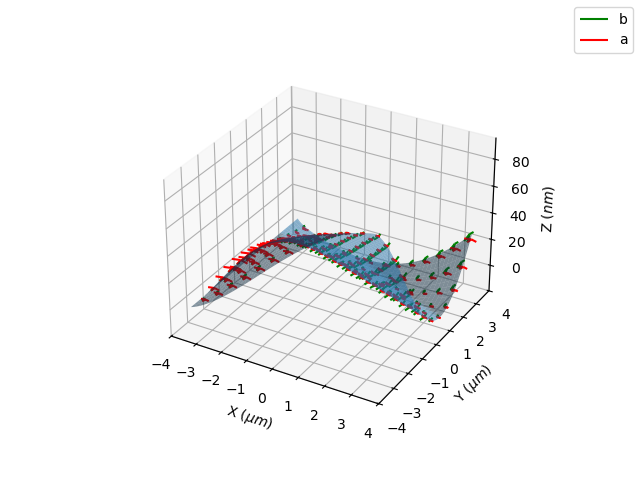

In [55]:
my_surfs.visualize_vectors()

# Define the `Experiment` Class

For this we need:

1. electron energy (keV)

2. qs: 3xN ndarry of h, k, l indices to compute the dark field bend contours.

3. `Surface` class

4. either:

rotation matrices: 3x3xN ndarray of the transformation for the surface to simulate

or.

rotation_angles: size N ndarry of angles in radians

rotation_axis: 3xN or 3 size ndarray defining the rotation axis.

5. intensity_param: constant used in computing the bright field intensity. Larger values -> stronger bend contours.
        

In [58]:
# defining q with all vectors from h = [-2,2], k = [-2,2], l = 0
qs0 = np.array(np.meshgrid(np.linspace(-2,2,5), np.linspace(-2,2,5),0)).reshape((3,-1)).T
mask = np.abs(qs0).sum(axis = 1) != 0
qs0 = qs0[mask]

#defining rotation axes
k_alpha = xp.array((xp.sin(xp.deg2rad(10)), xp.cos(xp.deg2rad(10)), xp.sin(xp.deg2rad(10)) * 0))

#rotation angles
angles_alpha = xp.deg2rad(xp.linspace(-5, 5, 20))

rot_mat_alpha = get_rot_matrix_rodriguez(k_alpha, angles_alpha)


# define experiment
exp = Experiment.from_energy(
    200, # keV
    qs0,
    my_surfs,
    0.1,
    rotation_axis = k_alpha,
    rotation_angles = angles_alpha,
)

# Bend contour intensity simulation & plotting


/home/hebell/bendcontour/bendcontourpy/src/bendcontourpy/experiment.py:400: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(n_row, 10, figsize = (20,10))


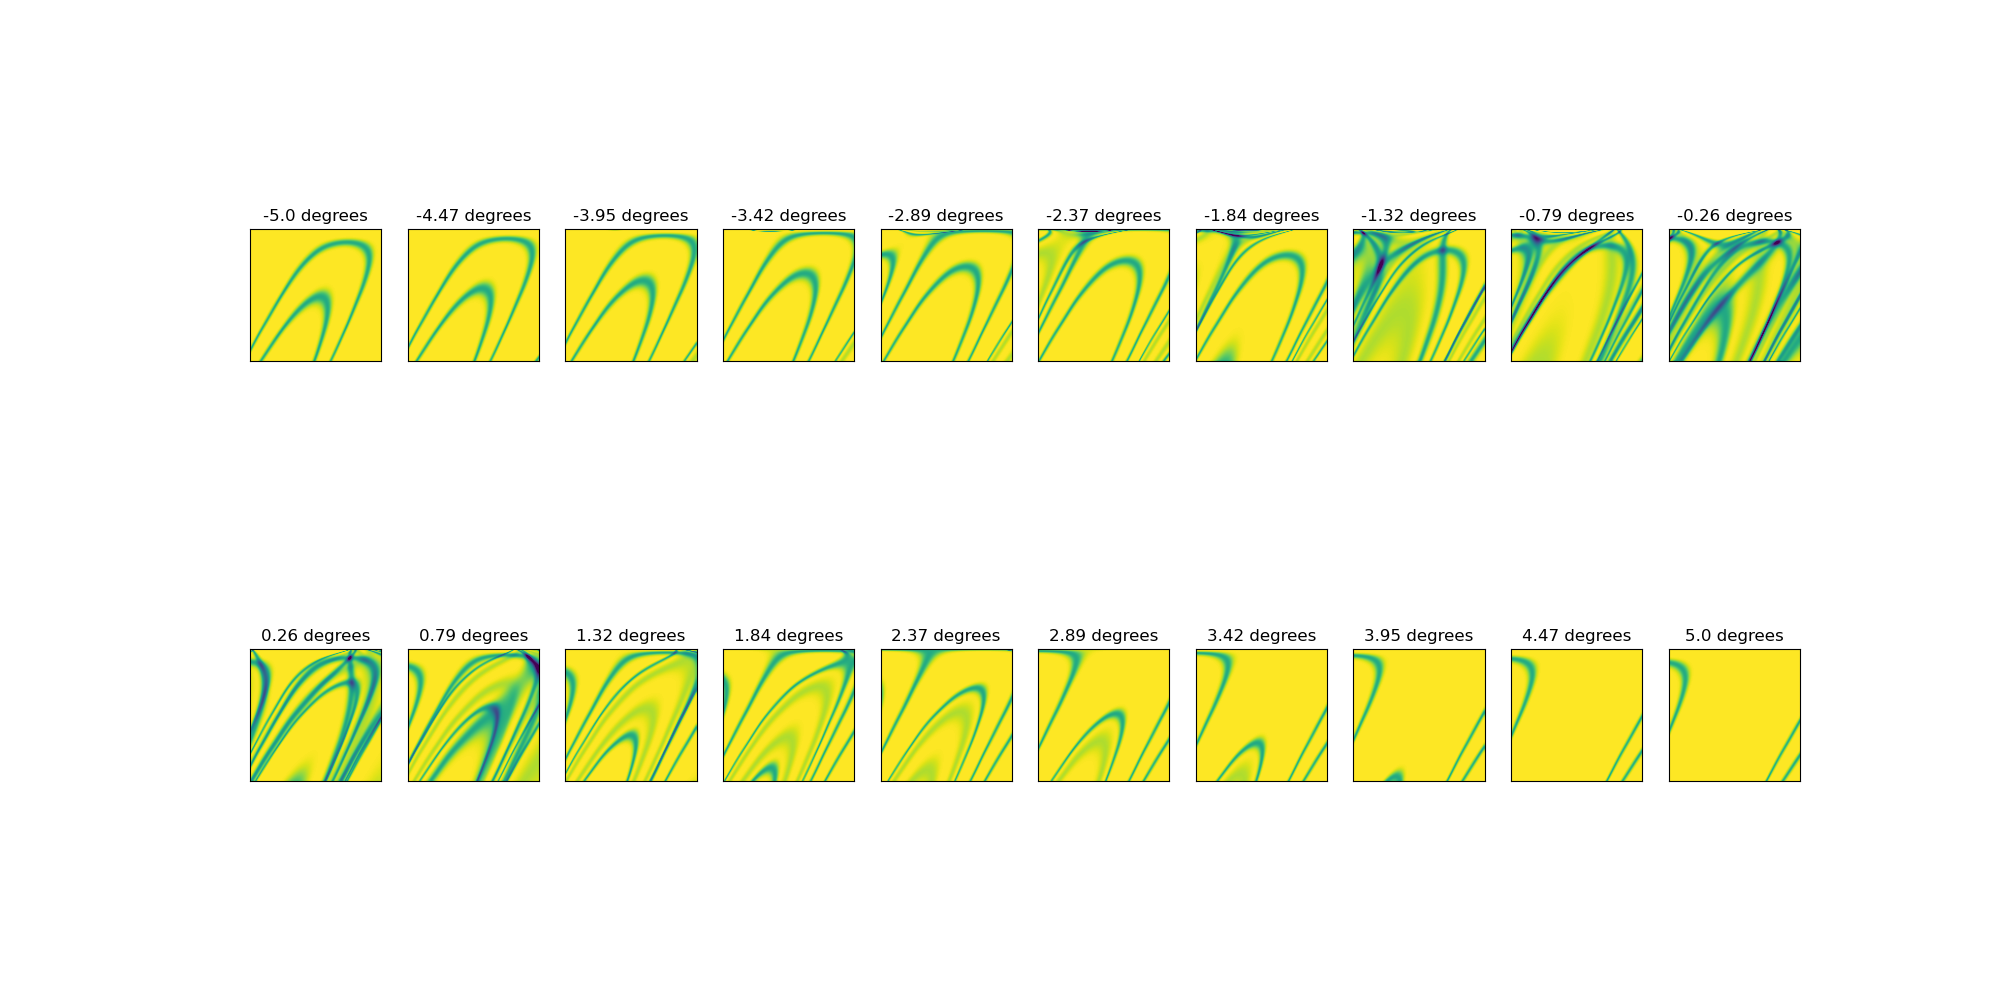

In [57]:
I_df, I_bf = exp.get_bright_field()

exp.plot_bf()